In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import f1_score

SEED = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cuda


In [43]:
df_train = pd.read_csv('pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [38]:
counts = df_train.groupby('sample_index')['time'].count().reset_index(name='n_timestamps')
counts = counts.sort_values('sample_index')

avg_ts = counts['n_timestamps'].mean()
print(f"Average number of timestamps per sample_index: {avg_ts:.2f}")

print(counts)

Average number of timestamps per sample_index: 160.00
     sample_index  n_timestamps
0               0           160
1               1           160
2               2           160
3               3           160
4               4           160
..            ...           ...
656           656           160
657           657           160
658           658           160
659           659           160
660           660           160

[661 rows x 2 columns]


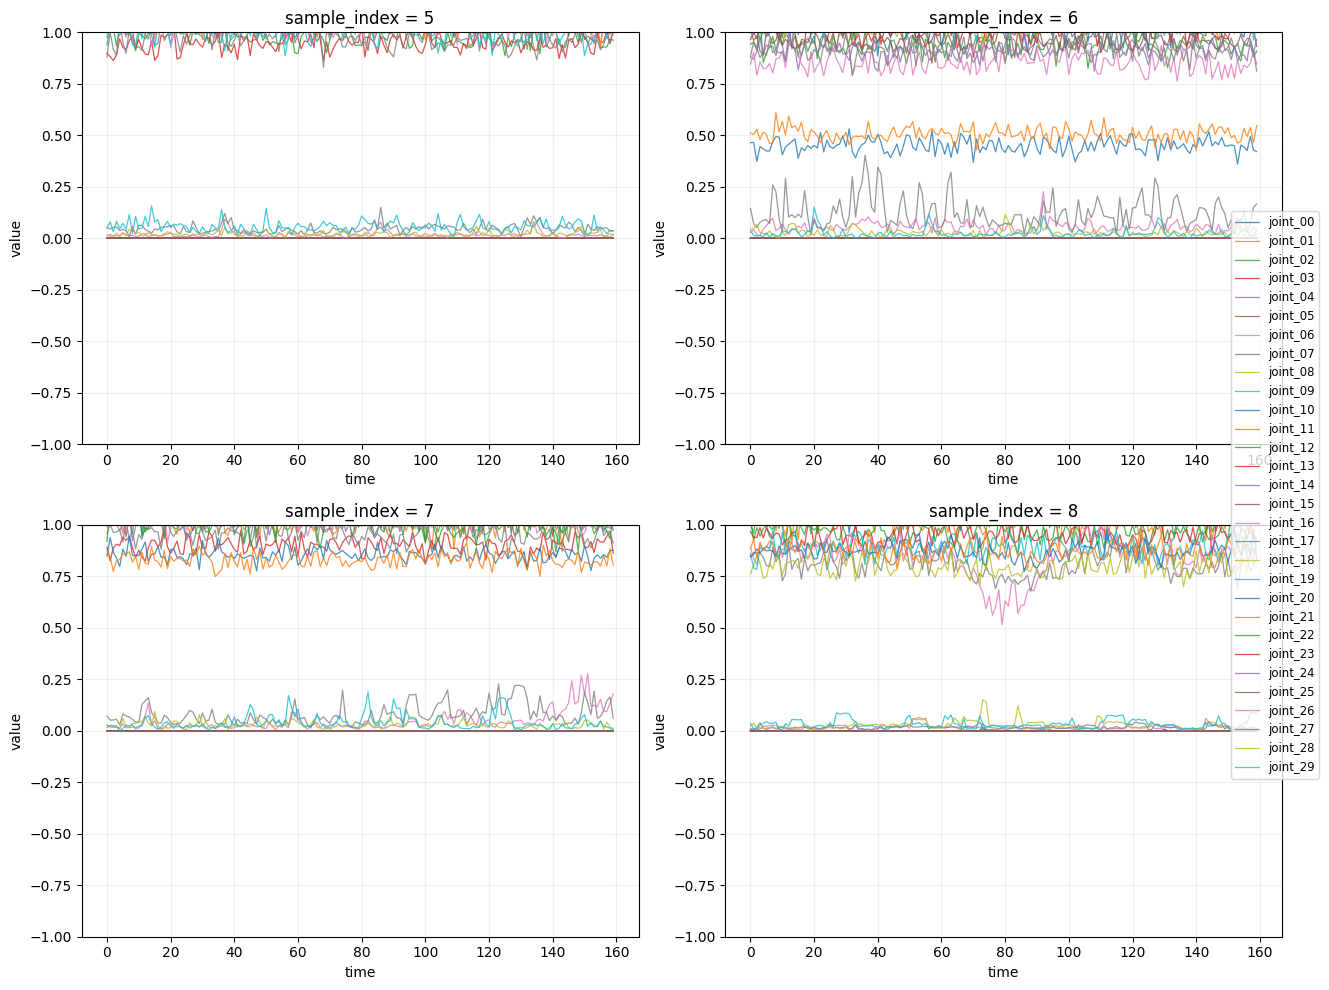

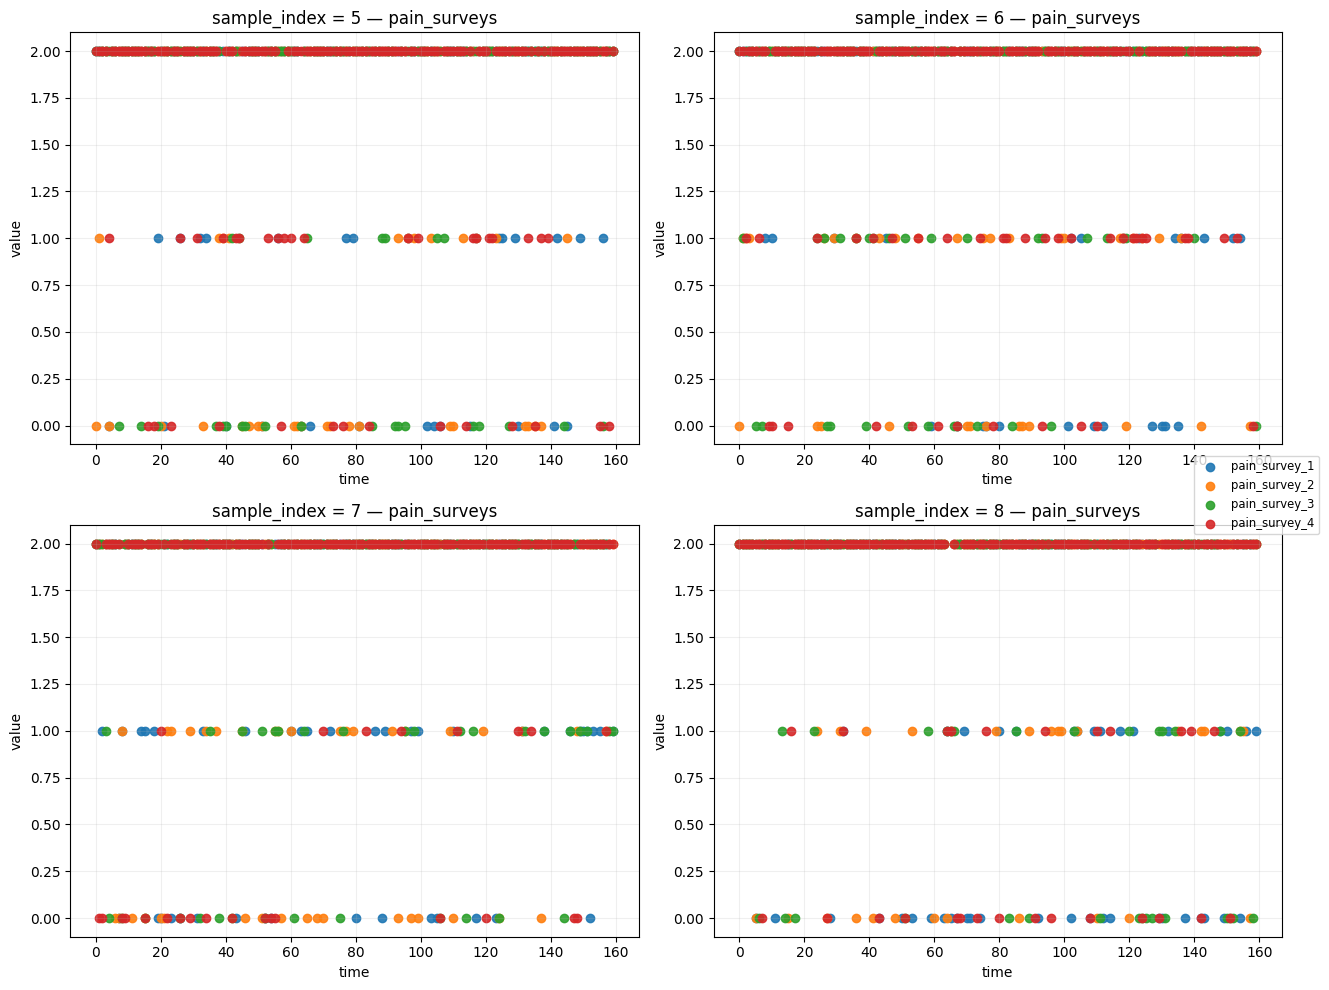

In [39]:
unique_sids = df_train['sample_index'].unique()

idxs = [5, 6, 7, 8]
sample_ids = unique_sids[idxs]

joint_cols = [c for c in df_train.columns if c.startswith('joint_')]

n_plot = min(len(joint_cols), 30)


fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
axes = axes.flatten()
for ax, sid in zip(axes, sample_ids):
    sub = df_train[df_train['sample_index'] == sid].sort_values('time')
    for j in joint_cols[:n_plot]:
        ax.plot(sub['time'], sub[j], label=j, linewidth=0.9, alpha=0.8)
    ax.set_title(f'sample_index = {sid}')
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.set_ylim(-1, 1)
    ax.grid(alpha=0.2)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), ncol=1, fontsize='small')
plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.show()



pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
axes = axes.flatten()
for ax, sid in zip(axes, sample_ids):
    sub = df_train[df_train['sample_index'] == sid].sort_values('time')
    for p in pain_cols:
        ax.scatter(sub['time'], sub[p], label=p, linewidth=1.0, alpha=0.9)
    ax.set_title(f'sample_index = {sid} — pain_surveys')
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    ax.grid(alpha=0.2)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), fontsize='small')
plt.tight_layout(rect=[0, 0, 0.93, 1])
plt.show()


In [40]:
# Save multiple dataframes by id
sub_df = np.ndarray(len(unique_sids), dtype=object)
for i in range(len(unique_sids)):
    sub_df[i] = df_train[df_train['sample_index'] == sid]





In [44]:
df_labels = pd.read_csv('pirate_pain_train_labels.csv')
df_labels.head()



In [ ]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [46]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [48]:
# Check feature columns and data first
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
feature_cols = joint_cols + pain_cols

print("Feature columns info:")
print("\nJoint columns min/max before normalization:")
print(df_train[joint_cols].min().min())
print(df_train[joint_cols].max().max())

print("\nPain survey columns min/max:")
print(df_train[pain_cols].min().min())
print(df_train[pain_cols].max().max())

# Check for any NaN values
print("\nNaN values in features:")
print(df_train[feature_cols].isna().sum())

# Create sequences with clean data
sequences = []
labels = []

for sid in df_train['sample_index'].unique():
    seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
    sequences.append(torch.FloatTensor(seq))
    labels.append(df_labels[df_labels['sample_index'] == sid]['label'].values[0])

# Normalize each sequence individually (only normalize joint data, not pain surveys)
for i in range(len(sequences)):
    # Get joint columns portion of the sequence
    joint_data = sequences[i][:, :len(joint_cols)]

    # Normalize joints to [-1, 1]
    joint_min = joint_data.min(dim=0)[0]
    joint_max = joint_data.max(dim=0)[0]
    joint_range = joint_max - joint_min
    joint_range[joint_range == 0] = 1  # Prevent division by zero
    normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1

    # Put normalized data back
    sequences[i][:, :len(joint_cols)] = normalized_joints

# Check sequences after normalization
print("\nChecking sequences after normalization:")
for i in range(min(5, len(sequences))):
    seq = sequences[i]
    print(f"\nSequence {i} shape:", seq.shape)
    print("Joint stats (first half of features):")
    joint_part = seq[:, :len(joint_cols)]
    print(f"min: {joint_part.min():.4f}, max: {joint_part.max():.4f}, mean: {joint_part.mean():.4f}")
    print("Pain survey stats (second half of features):")
    pain_part = seq[:, len(joint_cols):]
    print(f"min: {pain_part.min():.4f}, max: {pain_part.max():.4f}, mean: {pain_part.mean():.4f}")


# Convert labels to numeric
label_map = {label: i for i, label in enumerate(sorted(set(labels)))}
labels = [label_map[l] for l in labels]



Feature columns info:

Joint columns min/max before normalization:
0.0
1.631494402885437

Pain survey columns min/max:
0
2

NaN values in features:
joint_00         0
joint_01         0
joint_02         0
joint_03         0
joint_04         0
joint_05         0
joint_06         0
joint_07         0
joint_08         0
joint_09         0
joint_10         0
joint_11         0
joint_12         0
joint_13         0
joint_14         0
joint_15         0
joint_16         0
joint_17         0
joint_18         0
joint_19         0
joint_20         0
joint_21         0
joint_22         0
joint_23         0
joint_24         0
joint_25         0
joint_26         0
joint_27         0
joint_28         0
joint_29         0
joint_30         0
pain_survey_1    0
pain_survey_2    0
pain_survey_3    0
pain_survey_4    0
dtype: int64

Checking sequences after normalization:

Sequence 0 shape: torch.Size([160, 35])
Joint stats (first half of features):
min: -1.0000, max: 1.0000, mean: -0.4420
Pain survey s

In [ ]:

# Split into train/validation
train_idx, val_idx = train_test_split(range(len(sequences)), test_size=0.2, random_state=SEED, stratify=labels)

train_sequences = [sequences[i] for i in train_idx]
train_labels = torch.LongTensor([labels[i] for i in train_idx])
val_sequences = [sequences[i] for i in val_idx]
val_labels = torch.LongTensor([labels[i] for i in val_idx])


class PainDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create train/val datasets
train_dataset = PainDataset(train_sequences, train_labels)
val_dataset = PainDataset(val_sequences, val_labels)


def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences = pad_sequence(sequences, batch_first=True)
    return sequences, torch.stack(labels)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# Check raw data and feature statistics
print("Feature columns info:")
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
feature_cols = joint_cols + pain_cols

print("\nJoint columns min/max before normalization:")
print(df_train[joint_cols].min().min())
print(df_train[joint_cols].max().max())

print("\nPain survey columns min/max:")
print(df_train[pain_cols].min().min())
print(df_train[pain_cols].max().max())

# Check for any NaN values
print("\nNaN values in features:")
print(df_train[feature_cols].isna().sum().sum())

# Check sequence creation
print("\nSample index unique values:")
print(df_train['sample_index'].nunique())
print("\nLabels shape:")
print(df_labels.shape)

# Verify label matching
print("\nSample indices in labels that are not in features:")
train_samples = set(df_train['sample_index'].unique())
label_samples = set(df_labels['sample_index'].unique())
print(label_samples - train_samples)


In [ ]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.batch_norm = nn.BatchNorm1d(input_size)


        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Get a sample sequence to determine max sequence length
max_seq_len = max(len(seq) for seq in sequences)

# Create model and display architecture with parameter count
input_size = len(feature_cols)  # Number of features (joints + pain surveys)
num_classes = len(label_map)    # Number of unique labels

# Create model with correct input size
rnn_model = RecurrentClassifier(
    input_size=input_size,      # Number of input features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)

# Call recurrent_summary with correct input shape
recurrent_summary(rnn_model, input_size=(max_seq_len, input_size))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 160, 128], [2, -1, 128]] 54,144         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,531
Trainable params: 54,531
Non-trainable params: 0
-------------------------------------------------------------------------------


In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 5          # Number of users for validation split
N_TEST_USERS = 5         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 200        # Input window size
STRIDE = 50              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)


            # Check loss for NaN
            if torch.isnan(loss):
                print(f"NaN loss at batch {batch_idx}")
                print(f"Input range: [{inputs.min():.4f}, {inputs.max():.4f}]")
                print(f"Logits range: [{logits.min():.4f}, {logits.max():.4f}]")
                continue

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
import os
import copy
from itertools import chain

def k_fold_cross_validation(df_train, df_labels, epochs, criterion, device,
                            k, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            rnn_type, bidirectional, l1_lambda=0, l2_lambda=0, patience=0,
                            evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold cross-validation for pain classification using time series data.
    """
    # Initialize containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get feature columns
    joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
    pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
    feature_cols = joint_cols + pain_cols

    # Create global label mapping to ensure consistency across folds
    label_map = {label: i for i, label in enumerate(sorted(df_labels['label'].unique()))}
    num_classes = len(label_map)

    # Initialize model architecture
    model = RecurrentClassifier(
        input_size=len(feature_cols),
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = model.state_dict().copy()

    # Get unique sample indices for splitting
    unique_samples = df_train['sample_index'].unique()
    np.random.seed(seed)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    # Create k folds
    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]

    # Iterate through K folds
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\nFold {fold_idx+1}/{k}")

        # Use current fold as validation set, rest as training set
        val_samples = folds[fold_idx]
        train_samples = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))

        # Split data into train and validation
        train_data = []
        train_labels = []
        val_data = []
        val_labels = []

        # Create sequences for training set
        for sid in train_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            train_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            train_labels.append(label_map[label])

        # Create sequences for validation set
        for sid in val_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            val_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            val_labels.append(label_map[label])

        # Normalize sequences (only joint data)
        for sequences in [train_data, val_data]:
            for i in range(len(sequences)):
                joint_data = sequences[i][:, :len(joint_cols)]
                joint_min = joint_data.min(dim=0)[0]
                joint_max = joint_data.max(dim=0)[0]
                joint_range = joint_max - joint_min
                joint_range[joint_range == 0] = 1
                normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
                sequences[i][:, :len(joint_cols)] = normalized_joints

        # Create datasets and dataloaders
        train_dataset = PainDataset(train_data, torch.LongTensor(train_labels))
        val_dataset = PainDataset(val_data, torch.LongTensor(val_labels))

        train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size,
                              shuffle=False, collate_fn=collate_fn)

        if verbose > 0:
            print(f"  Training sequences: {len(train_data)}")
            print(f"  Validation sequences: {len(val_data)}")

        # Reset model to initial weights
        model.load_state_dict(initial_state)

        # Define optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current fold
        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=fold_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/fold_{fold_idx}"
        )

        # Store results for this fold
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        best_scores[f"fold_{fold_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])

    if verbose > 0:
        print(f"\nCross-validation score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:


def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-fold cross-validation for RNN models on the pain dataset.

    Args:
        df: DataFrame with full training time-series (indexed by sample_index)
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, device, seed, verbose)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with best_scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Prepare CV arguments
        epochs_val = cv_params.get('epochs', EPOCHS)
        criterion_val = cv_params.get('criterion', criterion)
        device_val = cv_params.get('device', device)
        k_val = cv_params.get('k', K)
        patience_val = cv_params.get('patience', PATIENCE)
        seed_val = cv_params.get('seed', SEED)
        verbose_cv = cv_params.get('verbose', 0)

        # Execute k-fold cross-validation using the notebook's label dataframe
        fold_losses, fold_metrics, fold_scores = k_fold_cross_validation(
            df_train=df,
            df_labels=df_labels,
            epochs=epochs_val,
            criterion=criterion_val,
            device=device_val,
            k=k_val,
            batch_size=run_params.get('batch_size', BATCH_SIZE),
            hidden_layers=run_params.get('hidden_layers', HIDDEN_LAYERS),
            hidden_size=run_params.get('hidden_size', HIDDEN_SIZE),
            learning_rate=run_params.get('learning_rate', LEARNING_RATE),
            dropout_rate=run_params.get('dropout_rate', DROPOUT_RATE),
            rnn_type=run_params.get('rnn_type', RNN_TYPE),
            bidirectional=run_params.get('bidirectional', BIDIRECTIONAL),
            l1_lambda=run_params.get('l1_lambda', L1_LAMBDA),
            l2_lambda=run_params.get('l2_lambda', L2_LAMBDA),
            patience=patience_val,
            verbose=verbose_cv,
            seed=seed_val,
            experiment_name=config_str
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration based on mean F1
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'fold_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'fold_{i}'])
        boxplot_data.append(split_scores)

        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} folds, expected {k_splits}")

        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)
        for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showmeans=True, meanline=True)

    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    if labels:
        ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Folds')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()


In [ ]:
%%time
# Define parameters to search
param_grid = {
    'dropout_rate': [0.1, 0.25, 0.5],
    'batch_size': [32, 64],
    'learning_rate': [1e-4, 1e-5],
    'l1_lambda': [0.0, 1e-3],
    'l2_lambda': [0.0, 1e-3]
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'n_test_users': N_TEST_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df_train,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/48:
  dropout_rate: 0.1
  batch_size: 32
  learning_rate: 0.0001
  l1_lambda: 0.0
  l2_lambda: 0.0
Training 500 epochs...
Training 500 epochs...
Early stopping triggered after 79 epochs.
Best model restored from epoch 29 with val_f1 0.7635
Early stopping triggered after 79 epochs.
Best model restored from epoch 29 with val_f1 0.7635
Training 500 epochs...
Training 500 epochs...
Early stopping triggered after 143 epochs.
Best model restored from epoch 93 with val_f1 0.7775
Early stopping triggered after 143 epochs.
Best model restored from epoch 93 with val_f1 0.7775
Training 500 epochs...
Training 500 epochs...
Early stopping triggered after 51 epochs.
Best model restored from epoch 1 with val_f1 0.9136
Early stopping triggered after 51 epochs.
Best model restored from epoch 1 with val_f1 0.9136
Training 500 epochs...
Training 500 epochs...
Early stopping triggered after 53 epochs.
Best model restored from epoch 3 with val_f1 0.9366
Early stopping triggered after 53 ep

/tmp/ipykernel_242825/2010613499.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showmeans=True, meanline=True)


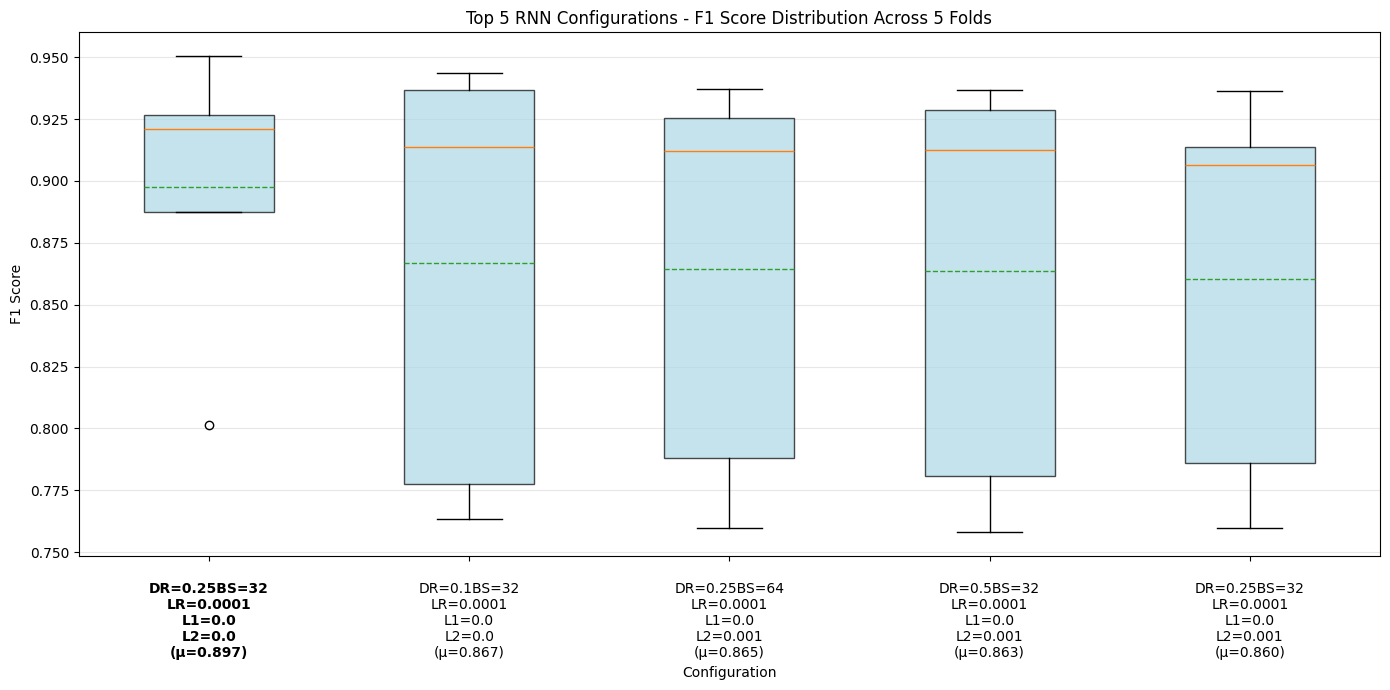

In [ ]:
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# Prepare test set
df_test = pd.read_csv('pirate_pain_test.csv')

# Convert float64 to float32
float_cols = df_test.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_test[col] = df_test[col].astype(np.float32)

# Create test sequences
test_sequences = []
test_indices = []

for sid in df_test['sample_index'].unique():
    seq = df_test[df_test['sample_index'] == sid].sort_values('time')[feature_cols].values
    test_sequences.append(torch.FloatTensor(seq))
    test_indices.append(sid)

# Normalize each sequence individually (only normalize joint data, not pain surveys)
for i in range(len(test_sequences)):
    joint_data = test_sequences[i][:, :len(joint_cols)]
    joint_min = joint_data.min(dim=0)[0]
    joint_max = joint_data.max(dim=0)[0]
    joint_range = joint_max - joint_min
    joint_range[joint_range == 0] = 1
    normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
    test_sequences[i][:, :len(joint_cols)] = normalized_joints

# Create test dataset and dataloader
class TestDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

# --- Determine best configuration and (re)train on full training set ---
if 'best_config' not in globals() or best_config is None:
    raise RuntimeError('best_config not found. Run the grid-search cell first to obtain best_config.')

# Merge best config with fixed params (fixed_params should exist from grid search cell)
run_params = {**fixed_params, **best_config}
config_str = "_".join([f"{k}_{v}" for k, v in run_params.items() if k in best_config])
print(f"Using best configuration: {run_params}")

# Build model with best hyperparameters
input_size = len(feature_cols)
num_classes = len(label_map)

best_model = RecurrentClassifier(
    input_size=input_size,
    hidden_size=run_params.get('hidden_size', HIDDEN_SIZE),
    num_layers=run_params.get('hidden_layers', HIDDEN_LAYERS),
    num_classes=num_classes,
    rnn_type=run_params.get('rnn_type', "LTSM"),
    bidirectional=run_params.get('bidirectional', True),
    dropout_rate=run_params.get('dropout_rate', DROPOUT_RATE)
).to(device)

# Create dataset with all training sequences (retrain on full data)
# Ensure `sequences` and `labels` variables exist and are aligned (they were created earlier)
if 'sequences' not in globals() or 'labels' not in globals():
    raise RuntimeError('Training sequences/labels not found in notebook. Run data preprocessing cells first.')

full_train_dataset = PainDataset(sequences, torch.LongTensor(labels))
full_train_loader = DataLoader(full_train_dataset, batch_size=run_params.get('batch_size', BATCH_SIZE), shuffle=True, collate_fn=collate_fn)

# Optimizer and scaler
optimizer = torch.optim.AdamW(best_model.parameters(), lr=run_params.get('learning_rate', LEARNING_RATE), weight_decay=run_params.get('l2_lambda', L2_LAMBDA))
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Retrain on full training set (no validation) for a modest number of epochs
retrain_epochs = cv_params.get('epochs', EPOCHS) if 'cv_params' in globals() else EPOCHS
retrain_epochs = min(retrain_epochs, 200)

print(f"Retraining best model on full training set for {retrain_epochs} epochs...")
best_model, _ = fit(
    model=best_model,
    train_loader=full_train_loader,
    val_loader=full_train_loader,
    epochs=retrain_epochs,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=run_params.get('l1_lambda', L1_LAMBDA),
    l2_lambda=run_params.get('l2_lambda', L2_LAMBDA),
    patience=0,
    restore_best_weights=False,
    verbose=1,
    experiment_name=f"best_{config_str}"
)

# Save final best model
os.makedirs('models', exist_ok=True)
torch.save(best_model.state_dict(), f"models/best_model_{config_str}.pt")
print(f"Best model saved to models/best_model_{config_str}.pt")

# --- Run predictions on test set ---

test_dataset = TestDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=run_params.get('batch_size', BATCH_SIZE), shuffle=False, collate_fn=lambda x: pad_sequence(x, batch_first=True))

best_model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = best_model(batch)
        pred = outputs.argmax(dim=1).cpu().numpy()
        predictions.extend(pred)

# Map numeric predictions back to label strings
inv_label_map = {v: k for k, v in label_map.items()}
labels_out = [inv_label_map[p] for p in predictions]

# Create output dataframe with formatted sample_index
output_df = pd.DataFrame({
    'sample_index': [f"{int(idx):03d}" for idx in test_indices],
    'label': labels_out
})

# Save to CSV
output_df.to_csv('best_predictions.csv', index=False)
print("Predictions saved to best_predictions.csv")
print(output_df.head())

Using best configuration: {'hidden_layers': 2, 'hidden_size': 128, 'dropout_rate': 0.25, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'rnn_type': 'GRU', 'bidirectional': False, 'batch_size': 32, 'learning_rate': 0.0001}
Retraining best model on full training set for 500 epochs...
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0162, F1 Score=0.6794 | Val: Loss=0.9719, F1 Score=0.6803
Epoch   1/500 | Train: Loss=1.0162, F1 Score=0.6794 | Val: Loss=0.9719, F1 Score=0.6803
Epoch   2/500 | Train: Loss=0.9370, F1 Score=0.6850 | Val: Loss=0.8905, F1 Score=0.6834
Epoch   3/500 | Train: Loss=0.8501, F1 Score=0.6828 | Val: Loss=0.8016, F1 Score=0.6892
Epoch   2/500 | Train: Loss=0.9370, F1 Score=0.6850 | Val: Loss=0.8905, F1 Score=0.6834
Epoch   3/500 | Train: Loss=0.8501, F1 Score=0.6828 | Val: Loss=0.8016, F1 Score=0.6892
Epoch   4/500 | Train: Loss=0.7597, F1 Score=0.6828 | Val: Loss=0.7070, F1 Score=0.6826
Epoch   5/500 | Train: Loss=0.6793, F1 Score=0.6855 | Val: Loss=0.6400, F1 Score=0.6895
E